In [11]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [12]:
df = pd.read_csv('Validation error of 305 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,-25.723286,36.284665,-2.057177,1.195648,0.876498,-12.665601,-32.985568,3.796000e+27,1111.111112,...,-14.838882,-5.884384,-2.302585,2.819544e+27,1514.274061,-7.517390,7.860765e+07,-14.968944,-5.139091,-1.543064
1,0,-12.434831,28.990187,-7.276390,-0.343827,-21.742832,-14.869335,-8.523659,1.771467e+27,1222.222224,...,-4.093484,-5.884384,-13.047982,1.551188e+27,1576.546729,-5.456213,1.045059e+08,-3.203445,-5.009415,-11.935817
2,0,26.330084,-12.018643,-4.929432,1.320529,-5.480527,5.530715,-2.338246,2.024533e+27,1777.777791,...,-9.466183,-16.629781,-7.675284,2.557595e+27,1564.113021,-8.999554,7.870466e+07,-8.947387,-17.549527,-7.495817
3,0,82.332995,-32.566815,-5.966929,1.617044,-10.559119,-5.243731,21.591845,1.771467e+27,1888.888896,...,-18.420681,-11.257083,-13.047982,3.229968e+27,1273.737937,-7.217305,5.683319e+07,-16.475619,-10.666792,-15.865282
4,0,-14.226143,-25.404561,-10.472461,-0.541119,-15.660339,0.801612,142.374692,3.796000e+27,1777.777791,...,-18.420681,-7.675284,-4.093484,3.255976e+27,1326.141149,-3.664796,6.103426e+07,-15.535940,-7.736810,-9.921570


In [13]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,304.0,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,3.040000e+02,304.000000,...,304.000000,304.000000,304.000000,3.040000e+02,304.000000,304.000000,3.040000e+02,304.000000,304.000000,304.000000
mean,0.0,5.975978,3.925543,-0.222487,-0.190879,0.518564,-2.624440,17.587022,2.648043e+27,1476.242698,...,-9.978710,-10.267375,-9.961037,2.587735e+27,1465.917676,-10.635980,7.941896e+07,-9.740025,-9.983978,-9.887652
std,0.0,39.061522,22.951747,16.139076,2.507099,18.158215,13.682473,93.593971,7.300488e+26,316.086134,...,5.211790,4.939696,5.204358,5.404846e+26,88.005781,5.269845,1.480399e+07,5.036052,4.948953,5.307100
min,0.0,-58.786062,-33.010764,-53.821237,-7.767760,-58.911260,-61.177476,-88.666408,1.518400e+27,1000.000000,...,-18.420681,-18.420681,-18.420681,1.489977e+27,1183.672994,-18.805758,5.625576e+07,-18.652377,-18.481839,-18.058724
25%,0.0,-21.253229,-15.970348,-7.293636,-1.794095,-8.698848,-7.963995,-24.596724,2.024533e+27,1222.222224,...,-14.838882,-14.838882,-14.838882,2.151712e+27,1421.070501,-15.432472,6.666830e+07,-14.366675,-13.842687,-14.419336
50%,0.0,-4.610214,-1.231367,-0.465058,-0.365114,0.240285,-1.732866,0.543715,2.783733e+27,1444.444448,...,-9.466183,-9.466183,-9.466183,2.593646e+27,1489.240721,-10.955711,7.881128e+07,-9.390851,-9.746013,-11.955883
75%,0.0,27.626751,21.633471,6.140673,1.162600,6.511058,3.216014,27.612771,3.289867e+27,1777.777791,...,-5.884384,-5.884384,-5.884384,3.104641e+27,1524.014115,-5.866112,9.234743e+07,-5.218619,-5.876882,-3.998823
max,0.0,119.239157,56.548190,79.595071,12.949917,73.114991,44.941407,684.280468,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,3.434304e+27,1653.333783,-1.521344,1.100235e+08,-1.518918,-1.318603,-0.849614


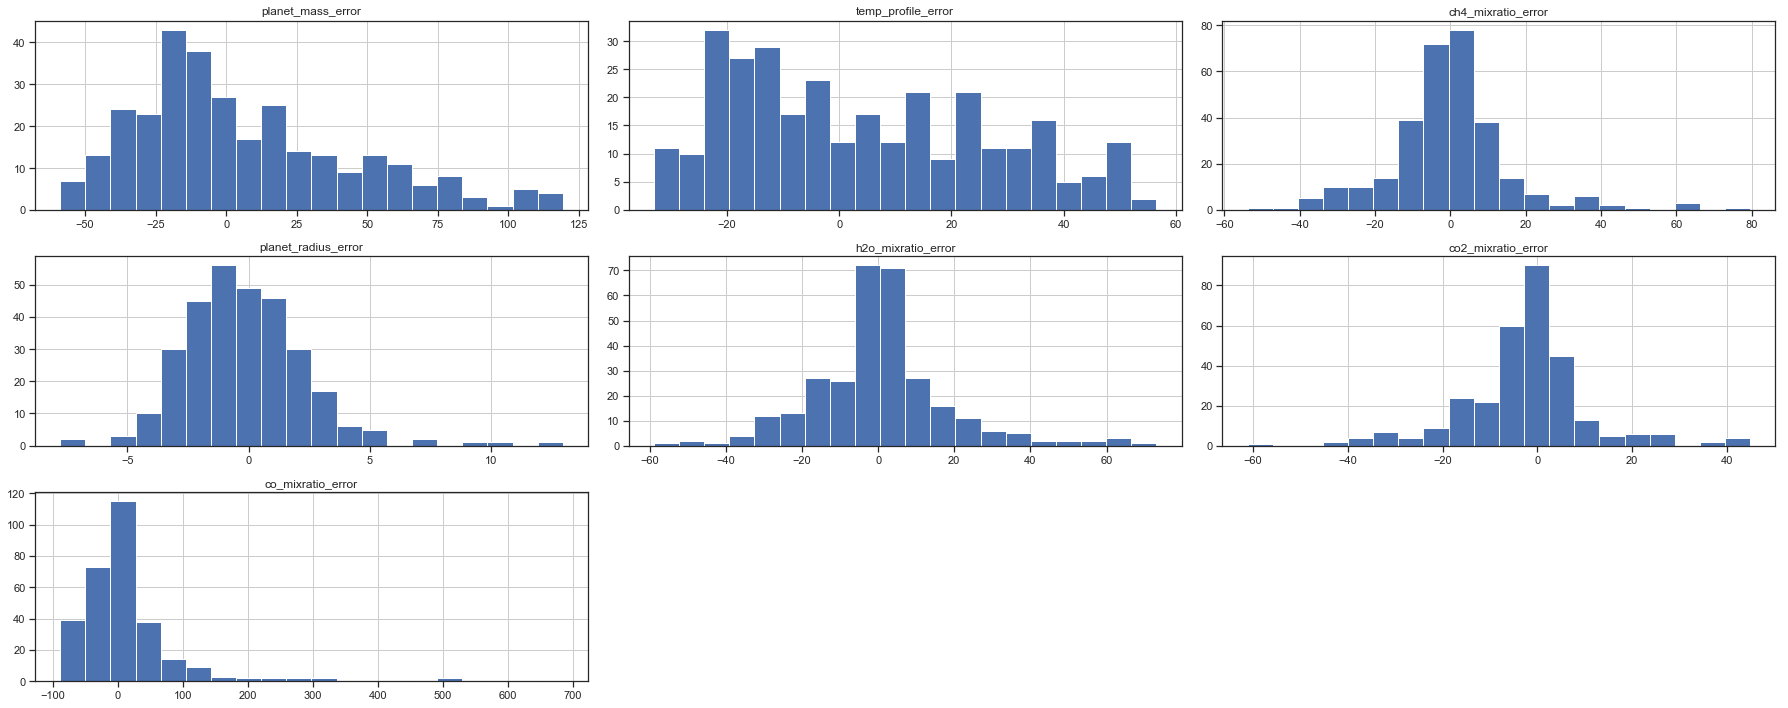

In [14]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

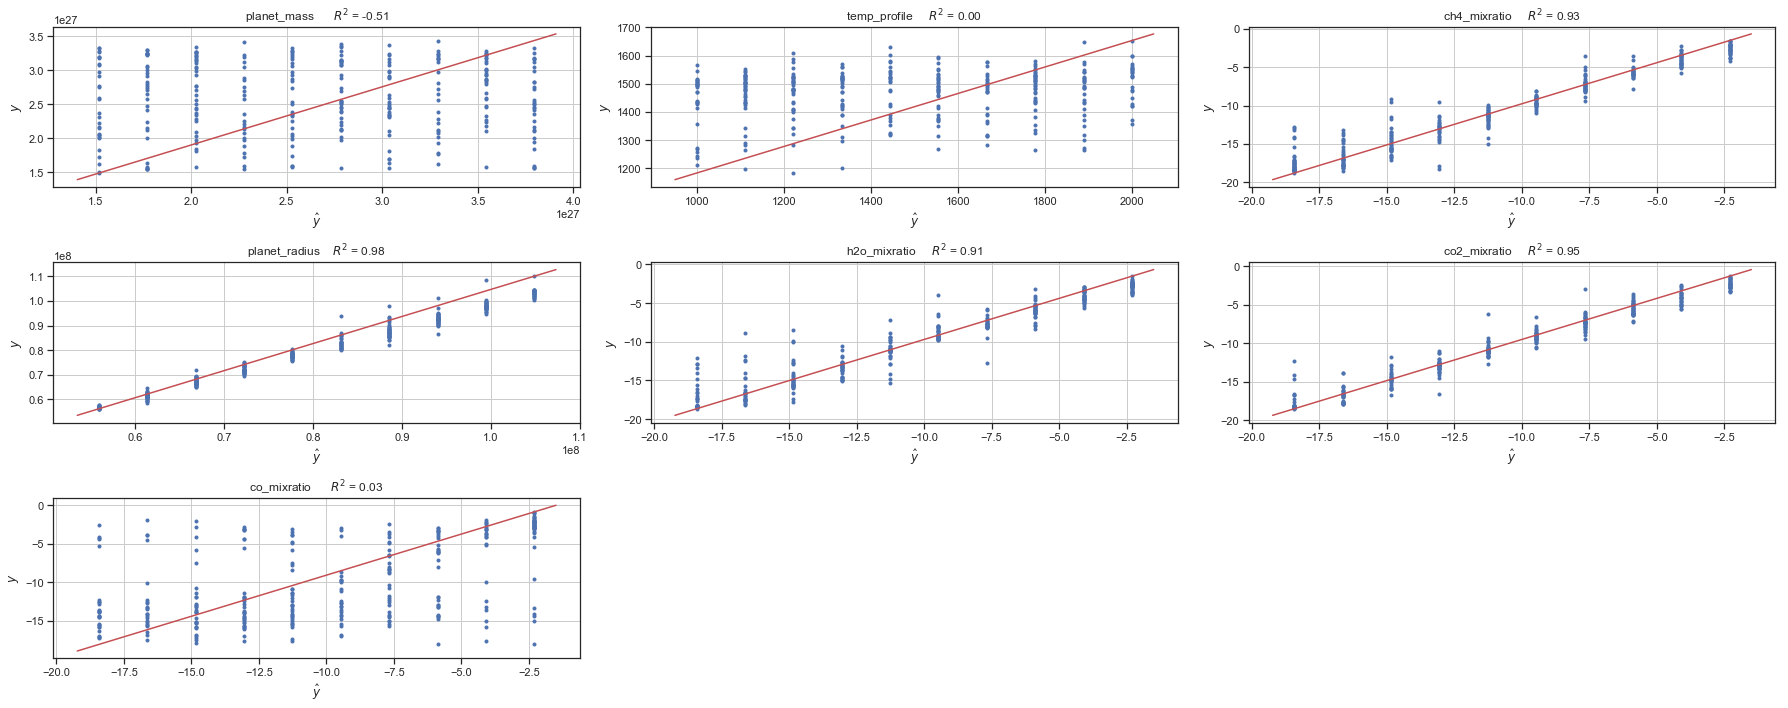

In [15]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)
    plt.title(param +' \t $R^2$ = %.2f' % r2)
    plt.plot(y_hat, y, '.')
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xlabel(r"$\hat{y}$")
    plt.ylabel(r"$y$")
    plt.grid()
    plt.tight_layout()